# Using Tensorflow Probability to improve model
From https://github.com/EiffL/Tutorials/blob/master/ClusterMasses/TFP_mass_estimate.ipynb

In [13]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from finetune import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
def binned_plot(X, Y, n=10, percentiles=[35, 50], ax=None, **kwargs):
    # Calculation
    calc_percent = []
    for p in percentiles:
        if p < 50:
            calc_percent.append(50-p)
            calc_percent.append(50+p)
        elif p == 50:
            calc_percent.append(50)
        else:
            raise Exception('Percentile > 50')

    bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

    dtype = [(str(i), 'f') for i in calc_percent]
    bin_data = np.zeros(shape=(n,), dtype=dtype)

    for i in range(n):
        y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

        if len(y) == 0:
            continue

        y_p = np.percentile(y, calc_percent)

        bin_data[i] = tuple(y_p)

    # Plotting
    if ax is None:
        f, ax = plt.subplots()

    bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]
    for p in percentiles:
        if p == 50:
            ax.plot(bin_centers, bin_data[str(p)], **kwargs)
        else:
            ax.fill_between(bin_centers,
                            bin_data[str(50-p)],
                            bin_data[str(50+p)],
                            alpha=0.2,
                            **kwargs)

    return bin_data, bin_edges


In [9]:
# Load up the most recent checkpointed model
model = regression_model()
model.load_weights('checkpoint-finetune.ckpt')

# Check that everything loaded fine - validation loss should be -1~
negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
            loss=negloglik)

vd = prepare_validation_data()
model.evaluate(vd[0], vd[1])

2023-07-11 14:17:01.076725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]
2023-07-11 14:17:01.077086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-07-11 14:17:03.295805: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shap

4/4 [==============================] - 4s 184ms/step - loss: -1.0890


-1.0890487432479858

In [12]:
# Load up the training data
ds = tfds.load('finetuning_data', split='train', as_supervised=True).batch(50)
dataset = ds.map(preprocess)

ds_np = list(dataset.unbatch().as_numpy_iterator())
images = []
labels = []
for thing in ds_np:
    images.append(thing[0])
    labels.append(thing[1])
images = np.array(images)
labels = np.array(labels)

y_pred = model(images).mean().numpy().squeeze()

2023-07-11 14:24:02.849570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-11 14:24:02.850577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


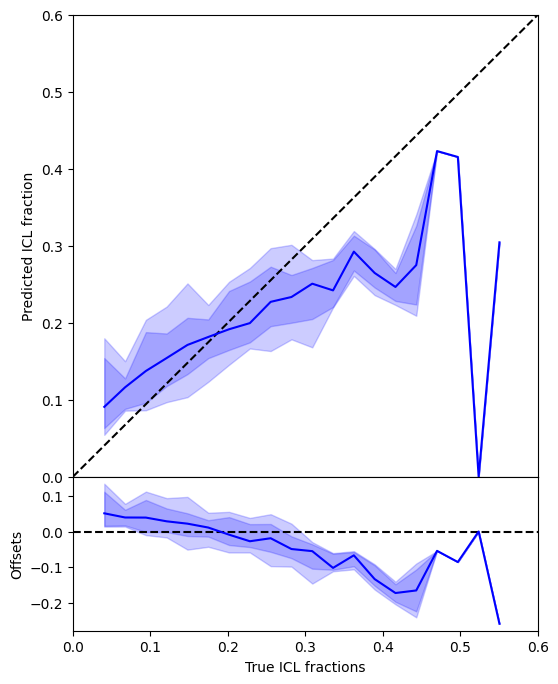

In [20]:
# Plot the results
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(np.arange(0, 0.6, 0.001), np.arange(0, 0.6, 0.001), 'k--')
_ = binned_plot(labels, y_pred, n=20, percentiles=[35,45,50], color='b', ax=ax1)

ax1.set_xlim(0, 0.6)
ax1.set_ylim(0, 0.6)
ax1.set_xticks([])
ax1.set_ylabel('Predicted ICL fraction')

ax2 = f.add_subplot(gs[1,0])
ax2.plot(np.linspace(0,0.6,10),[0]*10,'k--')
_ = binned_plot(labels, y_pred - labels, n=20, percentiles=[35,45,50], color='b', ax=ax2)

ax2.set_xlim(0,0.6)
ax2.set_xlabel('True ICL fractions')
ax2.set_ylabel('Offsets')

plt.show()

## Adjusting the prior distribution
Not currently working because of infs and nans

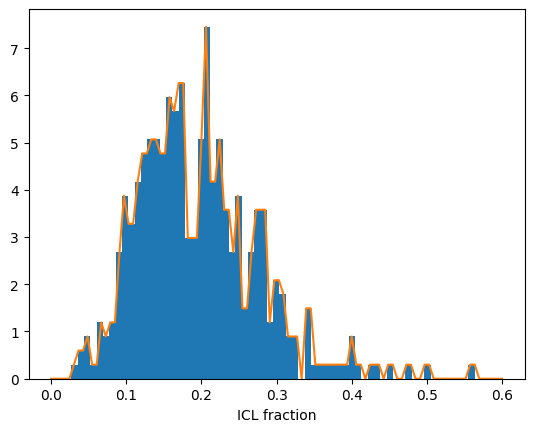

In [30]:
import scipy.stats 

# Plot the distribution of labels
hist = np.histogram(labels, 64)
prior = scipy.stats.rv_histogram(hist)

plt.hist(labels, 64, density=True)
x = np.linspace(0, 0.6,100)
plt.plot(x, prior.pdf(x))
plt.xlabel('ICL fraction')
plt.show()

In [24]:
# Compute the ICL fraction PDF predicted by the model for all clusters in the training set
outputs = model(images)
x = np.linspace(0, 0.6, 100)
logps = []

for i in x:
    logps.append(outputs.log_prob(i).numpy())
logps = np.stack(logps)

/tmp/ipykernel_415397/2255116472.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, np.exp(logps[:,i])/prior.pdf(x), label='under flat prior')
/tmp/ipykernel_415397/2255116472.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(x, np.exp(logps[:,i])/prior.pdf(x), label='under flat prior')


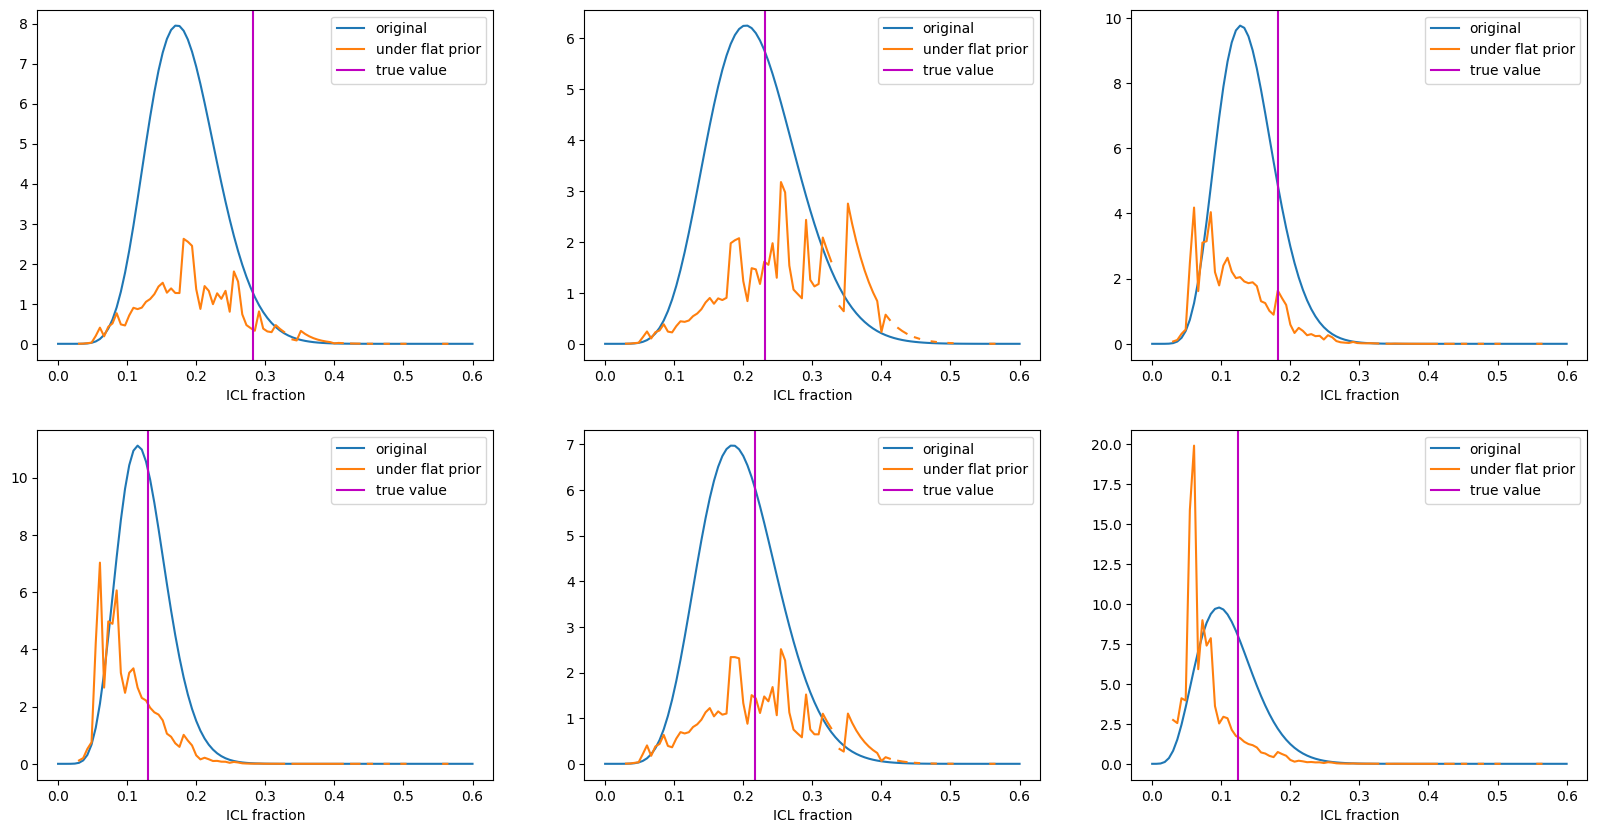

In [33]:
# Look at the effect of changing to a flat prior
idxs = [0, 500, 1000, 1500, 2000, 2500] # Indices to look at

plt.figure(figsize=(20,10))
for i, idx in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(x, np.exp(logps[:,i]), label='original')
    plt.plot(x, np.exp(logps[:,i])/prior.pdf(x), label='under flat prior')
    plt.axvline(labels[i], color='m', label='true value')
    plt.xlabel('ICL fraction')
    plt.legend()    

plt.show()

In [34]:
# Compute the corrected posterior for all clusters
from scipy.integrate import simps
corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))
y_pred_prior_mean = simps(x.reshape((-1,1))*corrected_posterior, x,axis=0)/simps(corrected_posterior,x,axis=0 )

/tmp/ipykernel_415397/3247192997.py:3: RuntimeWarning: divide by zero encountered in divide
  corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))
/tmp/ipykernel_415397/3247192997.py:3: RuntimeWarning: invalid value encountered in divide
  corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))
/tmp/ipykernel_415397/3247192997.py:4: RuntimeWarning: invalid value encountered in multiply
  y_pred_prior_mean = simps(x.reshape((-1,1))*corrected_posterior, x,axis=0)/simps(corrected_posterior,x,axis=0 )
/srv/scratch/z5214005/miniconda3/envs/tf2/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:749: RuntimeWarning: invalid value encountered in subtract
  result += alpha*y[slice1] + beta*y[slice2] - eta*y[slice3]


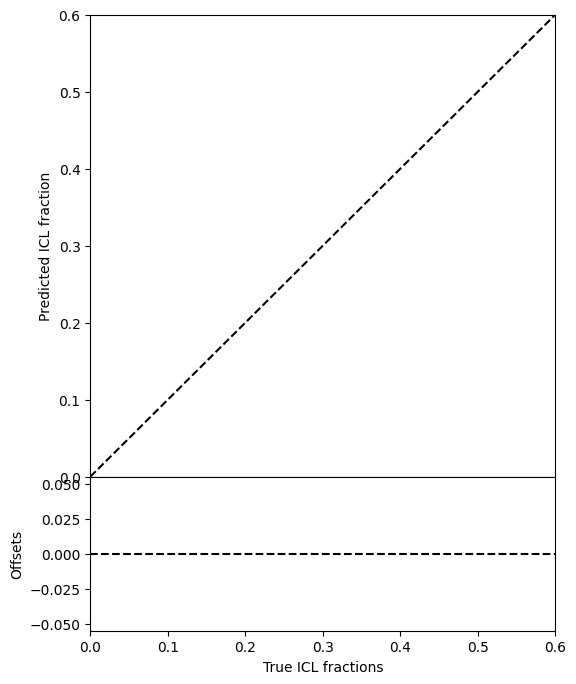

In [44]:
# Plot the results
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(np.arange(0, 0.6, 0.001), np.arange(0, 0.6, 0.001), 'k--')
_ = binned_plot(labels, y_pred_prior_mean, n=20, percentiles=[35,45,50], color='b', ax=ax1)

ax1.set_xlim(0, 0.6)
ax1.set_ylim(0, 0.6)
ax1.set_xticks([])
ax1.set_ylabel('Predicted ICL fraction')

ax2 = f.add_subplot(gs[1,0])
ax2.plot(np.linspace(0,0.6,10),[0]*10,'k--')
_ = binned_plot(labels, y_pred_prior_mean - labels, n=20, percentiles=[35,45,50], color='b', ax=ax2)

ax2.set_xlim(0,0.6)
ax2.set_xlabel('True ICL fractions')
ax2.set_ylabel('Offsets')

plt.show()

In [49]:
y_pred_mode = x[np.exp(logps).argmax(axis=0)]

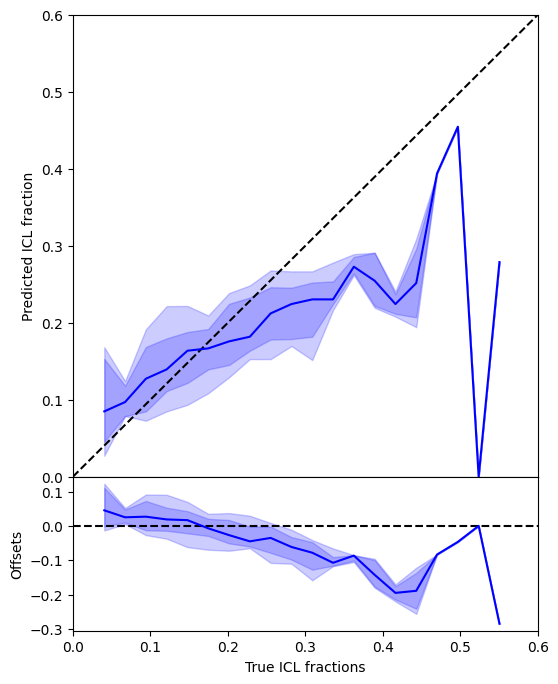

In [47]:
# Plot the results
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(np.arange(0, 0.6, 0.001), np.arange(0, 0.6, 0.001), 'k--')
_ = binned_plot(labels, y_pred_mode, n=20, percentiles=[35,45,50], color='b', ax=ax1)

ax1.set_xlim(0, 0.6)
ax1.set_ylim(0, 0.6)
ax1.set_xticks([])
ax1.set_ylabel('Predicted ICL fraction')

ax2 = f.add_subplot(gs[1,0])
ax2.plot(np.linspace(0,0.6,10),[0]*10,'k--')
_ = binned_plot(labels, y_pred_mode - labels, n=20, percentiles=[35,45,50], color='b', ax=ax2)

ax2.set_xlim(0,0.6)
ax2.set_xlabel('True ICL fractions')
ax2.set_ylabel('Offsets')

plt.show()